# Summary

This notebook will explore the LMP data from the NYISO website.

Questions to answer:
- How is the congestion data distributed?
- How has congestion increased/decreased over the past several years?
- What time of year is congestion most likely to occur?
- What are the most congested pricing points?
- Which pricing points have the longest sustained congestion?
- Which pricing points are traded the most in FTRs?

In [ ]:
import calendar
import datetime
import io
from zipfile import ZipFile

import gridstatus
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta

from adhoc_energy_analytics.constants import (
    get_default_download_dir,
    get_default_processed_dir,
)
from adhoc_energy_analytics.stats import freedman_diaconis_bins, trim_by_index

pd.set_option("display.float_format", "{:.5f}".format)


# subclass NYISO to override the _download_nyiso_archive method
class NYISOWithLocalZip(gridstatus.NYISO):

    # override init to set the download directory
    def __init__(self, *args, download_dir=None, **kwargs):
        if download_dir is None:
            download_dir = get_default_download_dir()
        self.download_dir = download_dir
        super().__init__(*args, **kwargs)

    def _download_nyiso_archive(
        self,
        date: str | pd.Timestamp,
        end: str | pd.Timestamp | None = None,
        dataset_name: str | None = None,
        filename: str | None = None,
        groupby: str | None = None,
        verbose: bool = False,
    ):
        """
        Override to prevent downloading from NYISO's website.
        Instead, we will read from a pre-downloaded zip file.
        """
        if filename is None:
            filename = dataset_name

        # NB: need to add the file date to the load forecast dataset to get the
        # forecast publish time.
        add_file_date = gridstatus.nyiso.LOAD_FORECAST_DATASET == dataset_name

        date = gridstatus.utils._handle_date(date, self.default_timezone)
        month = date.strftime("%Y%m01")
        day = date.strftime("%Y%m%d")

        # NB: if requesting the same day then just download the single file
        if end is not None and date.normalize() == end.normalize():
            end = None
            date = date.normalize()

        # NB: the last 7 days of file are hosted directly as csv
        # todo this can probably be optimized to a single csv in
        # a range and all files are in the last 7 days
        if end is None and date > pd.Timestamp.now(
            tz=self.default_timezone,
        ).normalize() - pd.DateOffset(days=7):
            raise NotImplementedError()
        else:
            # Get files from download dir
            zip_url = self.download_dir / f"{month}{filename}_csv.zip"
            if verbose:
                print(f"Reading from {zip_url}")
            with open(zip_url, "rb") as f:
                z = ZipFile(io.BytesIO(f.read()))

            all_dfs = []
            if end is None:
                date_range = [date]
            else:
                date_range = pd.date_range(
                    date.date(),
                    end.date(),
                    freq="1D",
                    inclusive="left",
                ).tolist()

                # NB: this handles case where end is the first of the next month
                # this pops up from the support_date_range decorator
                # and that date will be handled in the next month's zip file
                if end.month == date.month:
                    date_range += [end]

            for d in date_range:
                d = gridstatus.utils._handle_date(d, tz=self.default_timezone)
                month = d.strftime("%Y%m01")
                day = d.strftime("%Y%m%d")

                csv_filename = f"{day}{filename}.csv"
                if csv_filename not in z.namelist():
                    print(f"{csv_filename} not found in {zip_url}")
                    continue
                df = pd.read_csv(z.open(csv_filename))

                if add_file_date:
                    # NB: The File Date is the last modified time of the individual csv file
                    df["File Date"] = pd.Timestamp(
                        *z.getinfo(csv_filename).date_time,
                        tz=self.default_timezone,
                    )
                df = self._handle_time(df, dataset_name, groupby=groupby)

                # The column 'Marginal Cost Congestion ($/MWH' might exist,
                # in which case we need to add an ending 'r)'
                if "Marginal Cost Congestion ($/MWH" in df.columns:
                    df.rename(
                        columns={
                            "Marginal Cost Congestion ($/MWH": "Marginal Cost Congestion ($/MWHr)"
                        },
                        inplace=True,
                    )

                all_dfs.append(df)
            df = pd.concat(all_dfs)
        return df.sort_values("Time").reset_index(drop=True)


nyiso = NYISOWithLocalZip(download_dir=get_default_download_dir())

# Download the NYISO LMP data for the past 3 years

* I am assuming 2022-2025 is an acceptable "post-pandemic" period.

In [ ]:
def download_lmp_by_month(
    start_date: datetime.date, end_date: datetime.date
) -> pd.DataFrame:
    """
    Download NYISO LMP data one month at a time between start_date and end_date.
    Each month's data is saved as a separate parquet file in the default processed dir.
    Returns a concatenated DataFrame of all months.
    """
    processed_dir = get_default_processed_dir()
    processed_dir.mkdir(parents=True, exist_ok=True)

    current = datetime.date(start_date.year, start_date.month, 1)
    last = datetime.date(end_date.year, end_date.month, 1)

    dfs = []
    while current <= last:
        next_month = current + relativedelta(months=1)
        month_end = next_month - datetime.timedelta(seconds=1)

        out_path = processed_dir / f"nyiso_lmp_{current:%Y_%m}.parquet"
        if out_path.exists():
            print(f"Loading existing file {out_path}")
            df_month = pd.read_parquet(out_path)
        else:
            print(f"Downloading LMP data for {current:%Y-%m} to {out_path}")
            df_month = nyiso.get_lmp(
                date=current,
                end=month_end,
                market=gridstatus.Markets.DAY_AHEAD_HOURLY,
                locations="ALL",
                location_type=gridstatus.nyiso.GENERATOR,
                verbose=True,
            )
            df_month.to_parquet(out_path)

        dfs.append(df_month)
        current = next_month

    print(f"Concatenating {len(dfs)} months of data")
    return pd.concat(dfs, ignore_index=True).astype(
        {"Market": "category", "Location": "category", "Location Type": "category"}
    )


# example invocation
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2025, 6, 1) - datetime.timedelta(days=1)
df = download_lmp_by_month(start_date, end_date)

Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_01.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_02.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_03.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_04.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_05.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_06.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_07.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_08.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_09.parquet
L

In [38]:
df

,Time,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss
0,2010-01-01 00:00:00-05:00,2010-01-01 00:00:00-05:00,2010-01-01 01:00:00-05:00,DAY_AHEAD_HOURLY,59TH STREET_GT_1,Generator,47.48000,33.92000,10.44000,3.12000
1,2010-01-01 00:00:00-05:00,2010-01-01 00:00:00-05:00,2010-01-01 01:00:00-05:00,DAY_AHEAD_HOURLY,NEG WEST___LANCASTR,Generator,32.83000,33.91000,1.77000,-2.85000
2,2010-01-01 00:00:00-05:00,2010-01-01 00:00:00-05:00,2010-01-01 01:00:00-05:00,DAY_AHEAD_HOURLY,NEG WEST_LEA_LOCKPORT,Generator,32.24000,33.91000,1.45000,-3.12000
3,2010-01-01 00:00:00-05:00,2010-01-01 00:00:00-05:00,2010-01-01 01:00:00-05:00,DAY_AHEAD_HOURLY,NEG NORTH___PLATTSBURG,Generator,33.10000,33.91000,-0.00000,-0.81000
4,2010-01-01 00:00:00-05:00,2010-01-01 00:00:00-05:00,2010-01-01 01:00:00-05:00,DAY_AHEAD_HOURLY,NEG NORTH___LWR_SARANAC,Generator,33.10000,33.91000,-0.00000,-0.81000
...,...,...,...,...,...,...,...,...,...,...
75461766,2025-05-31 23:00:00-04:00,2025-05-31 23:00:00-04:00,2025-06-01 00:00:00-04:00,DAY_AHEAD_HOURLY,GILBOA___4,Generator,24.91000,24.21000,-0.00000,0.70000
75461767,2025-05-31 23:00:00-04:00,2025-05-31 23:00:00-04:00,2025-06-01 00:00:00-04:00,DAY_AHEAD_HOURLY,GILBOA____,Generator,24.91000,24.21000,-0.00000,0.70000
75461768,2025-05-31 23:00:00-04:00,2025-05-31 23:00:00-04:00,2025-06-01 00:00:00-04:00,DAY_AHEAD_HOURLY,GINNA____,Generator,22.76000,24.21000,-0.00000,-1.45000
75461769,2025-05-31 23:00:00-04:00,2025-05-31 23:00:00-04:00,2025-06-01 00:00:00-04:00,DAY_AHEAD_HOURLY,GARDNVLA_35_KV_LD,Generator,23.43000,24.20000,-0.00000,-0.77000


# How is the congestion data distributed?

Congestion is heavily skewed to the right, with more than 50% of values being less than 1.

In [3]:
df.Congestion.describe()

count   42057054.00000
mean           7.08454
std           16.72247
min         -823.22000
25%            0.00000
50%            0.82000
75%            7.73000
max         2210.33000
Name: Congestion, dtype: float64

In [3]:
trimmed_df = trim_by_index(df, trim_col="Congestion", lower_pct=0.1, upper_pct=0.1)
trimmed_vals = trimmed_df.Congestion

In [65]:
trimmed_vals.describe()

count   33645643.00000
mean           3.55984
std            5.05722
min           -0.00000
25%           -0.00000
50%            0.82000
75%            5.61000
max           20.43000
Name: Congestion, dtype: float64

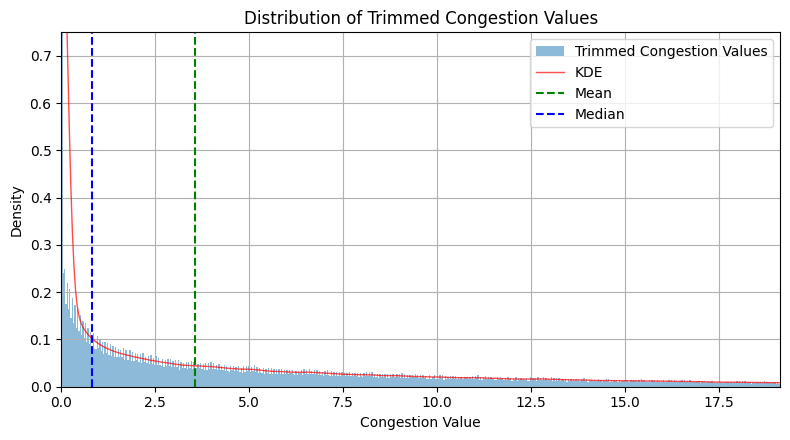

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Histogram of trimmed congestion values
bins = freedman_diaconis_bins(trimmed_vals)
ax.hist(
    trimmed_vals, bins=bins, density=True, alpha=0.5, label="Trimmed Congestion Values"
)

# KDE overlay
trimmed_vals.plot(kind="kde", ax=ax, color="red", linewidth=1, label="KDE", alpha=0.7)

# Mean & median lines
ax.axvline(trimmed_vals.mean(), color="green", linestyle="dashed", label="Mean")
ax.axvline(trimmed_vals.median(), color="blue", linestyle="dashed", label="Median")

# Axis limits, labels, title, legend, grid
ax.set_xlim(trimmed_vals.min(), trimmed_vals.quantile(0.99))
ax.set_ylim(0, 0.75)
ax.set_title("Distribution of Trimmed Congestion Values")
ax.set_xlabel("Congestion Value")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

# How has congestion increased/decreased over the past several years?

There was a significant increase in congestion starting around 2021, lasting through mid-2023. The reasons for congestion varied by year and highlights how many factors can contribute to congestion. The main reasons I could find for increased congestion revenues in the above timeframe are:
* Gas prices contributed to price spreads between regions, which increased redispatch costs to resolve congestion.
* Transmission outages to facilitate public policy projects
* Retirement of Indian Point nuclear station
* Transmission outages on tie lines between Long Island and upstate regions

In **2021**, congestion increased because of higher redispatch costs due to increased gas prices, bottlenecks from transmission upgrades, the [Indian Point nuclear station](https://en.wikipedia.org/wiki/Indian_Point_Energy_Center) retirement on April 30 and tie line outages. From the [2021 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2022/05/NYISO-2021-SOM-Full-Report_5-11-2022-final.pdf):

> Real-time prices varied from an average of $24.10 per MWh in the North Zone to $62.24 per MWh in Long Island in 2021 because of the effects of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2020 to 2021, up 72 to 78 percent in Western New York and 92 to 104 percent in Eastern New York. The increases across the system were driven primarily by higher natural gas prices. The larger increase in Eastern New York was mostly attributable to more severe transmission bottlenecks across the Central-East interface because of lengthy transmission outages taken to facilitate several Public Policy Transmission Projects and the retirements of Indian Point nuclear units. In addition, Long Island experienced lengthy transmission outages on both of its tie lines with upstate regions, leading to abnormally high levels of congestion and elevated energy prices on Long Island.
> 
> Consequently, congestion revenues collected in the day-ahead market rose 86 percent from 2020, totaling $551 million in 2021. (See Section VI.A) The following corridors accounted for most of the congestion in 2021:
> * Central-East Interface – 56 percent
> * Long Island – 12 percent
> * West Zone (flowing east) – 9 percent
> * North to Central New York – 6 percent
> * New York City – 6 percent

From section II.A of the report:

> Transmission congestion increased on paths from north-to-central New York, from central-to-eastern New York, and from upstate into Long Island. These increases were driven primarily by lengthy planned policy-driven transmission outages, the Indian Point 3 retirement at the end of April, and forced outages of key transmission lines during the summer months (especially into Long Island).

From section VII of the report:
> Higher natural gas prices and gas price spreads between regions, which increase redispatch costs to resolve congestion, were one of the main drivers of elevated congestion levels in 2021.

In **2022**, congestion rose *again* due to higher gas prices and more lengthy transmission outages for AC public policy projects.

From the [2022 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2023/05/NYISO-2022-SOM-Full-Report__5-16-2023-final.pdf):

> Real-time prices varied from an average of $50.46 per MWh in the North Zone to $108 per MWh in Long Island in 2022 because of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2021 to 2022, up 83 to 109 percent in Western New York and 73 to 126 percent in Eastern New York, primarily because of higher natural gas prices. The larger increases in eastern New York was largely attributable to: (a) more severe transmission bottlenecks across the Central-East interface due to lengthy transmission outages taken to facilitate the AC Public Policy Transmission Projects, and (b) larger gas price increases in eastern New York during the winter months.
> Consequently, congestion revenues collected in the day-ahead market rose 82 percent from 2021, totaling $1 billion in 2022. (See Section VI.A) The following corridors accounted for most congestion in 2022:
> * Central-East Interface – 60 percent
> * External Interfaces – 9 percent
> * Long Island – 9 percent

More from section II.A of the report:

> Transmission congestion became more severe, especially from Central New York to East New York and from upstate into Long Island, primarily because of lengthy forced transmission outages and planned outages related to ongoing efforts to upgrade segments of the transmission system. More is written on congestion patterns in Section VII.

In **2023**, congestion fell because gas prices went down, and the transmission projects from 2021-2022 completed (thereby reducing outages) and as a result there was increased transmission capability. Also, the mild winter weather helped reduce congstion on gas pipelines.

From the [2023 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2024/05/NYISO-2023-SOM-Full-Report__5-13-2024-Final.pdf):

> Average energy prices fell substantially from 2022 in Western New York (53 to 57 percent) and Eastern New York (58 to 65 percent) mainly because of lower gas prices and fewer transmission outages. Transmission congestion and losses in 2023 caused real-time prices to vary from $23.50 per MWh in the North Zone to $45.38 in Long Island on average. (See Section II.A)
>
> Price reductions were larger in eastern New York because transmission bottlenecks across the Central-East interface were alleviated by: (a) fewer planned transmission outages related to construction of the AC Public Policy Transmission Projects, (b) the increased transfer capability from the newly-built projects, and (c) mild winter weather conditions which helped reduce congestion on gas pipelines flowing into eastern New York. Consequently, congestion revenues collected in the day-ahead market fell 69 percent from 2022, totaling $311 million in 2023. (See Section VI.A) Most congestion in 2023 occurred on two corridors: the Central-East Interface (53 percent of all congestion) and Long Island (19 percent of all congestion).

From section VII of the report:
> Day-ahead congestion revenues fell to $311 million in 2023, marking a 69 percent decrease from 2022 and nearing the lowest level observed ($297 million) over the past decade. The sharp reduction in congestion was primarily attributable to lower natural gas prices and narrower gas price spreads between regions, which led to lower redispatch costs.
>
> Congestion was also reduced by less frequent planned transmission outages in 2023 than during the construction of major transmission projects over the past two years. As major transmission upgrades have been completed, congestion in the affected regions has been greatly reduced.

... etc.

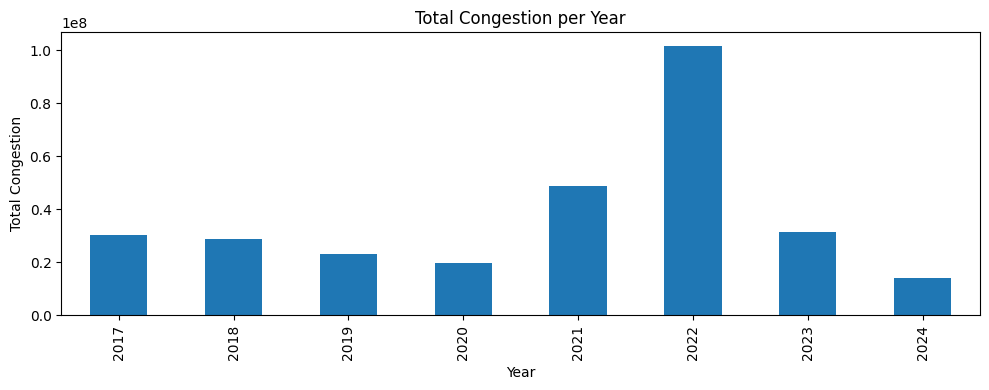

In [70]:
# What is the total congestion per year?
yearly_totals = df.groupby(df["Interval Start"].dt.year)["Congestion"].sum()

fig, ax = plt.subplots(figsize=(10, 4))
yearly_totals.plot(kind="bar", ax=ax)
ax.set_title("Total Congestion per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Total Congestion")
plt.tight_layout()
plt.show()

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_54009/1232962730.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df["Interval Start"].dt.to_period("M"))["Congestion"].sum().reset_index()


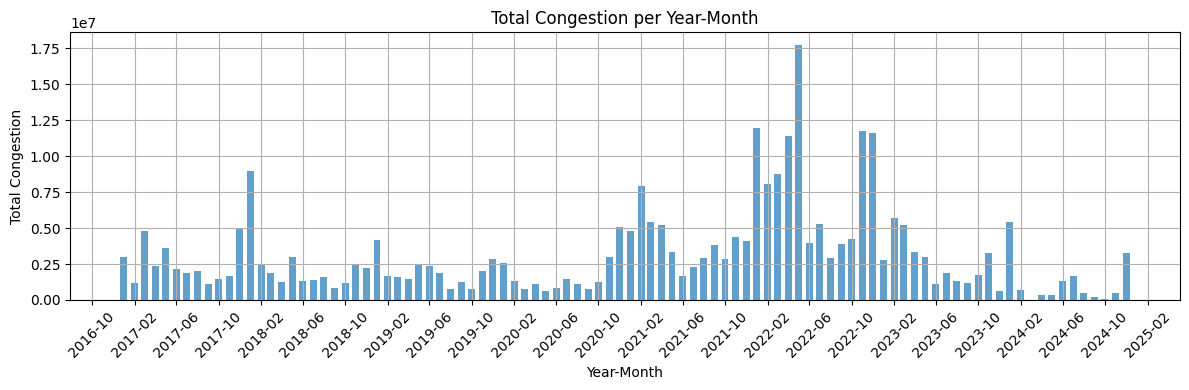

In [93]:
# Aggregate data
sum_cong_per_year_month = (
    df.groupby(df["Interval Start"].dt.to_period("M"))["Congestion"].sum().reset_index()
)
sum_cong_per_year_month["Interval Start"] = sum_cong_per_year_month[
    "Interval Start"
].dt.to_timestamp()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(
    sum_cong_per_year_month["Interval Start"],
    sum_cong_per_year_month["Congestion"],
    width=20,
    alpha=0.7,
)

# Format the x-axis: show a tick every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(axis="x", rotation=45)

ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Congestion")
ax.set_title("Total Congestion per Year-Month")
ax.grid()

plt.tight_layout()
plt.show()

# What time of year is congestion most likely to occur?

It looks like congestion in 2024 occurred most frequently in the summer and winter months.

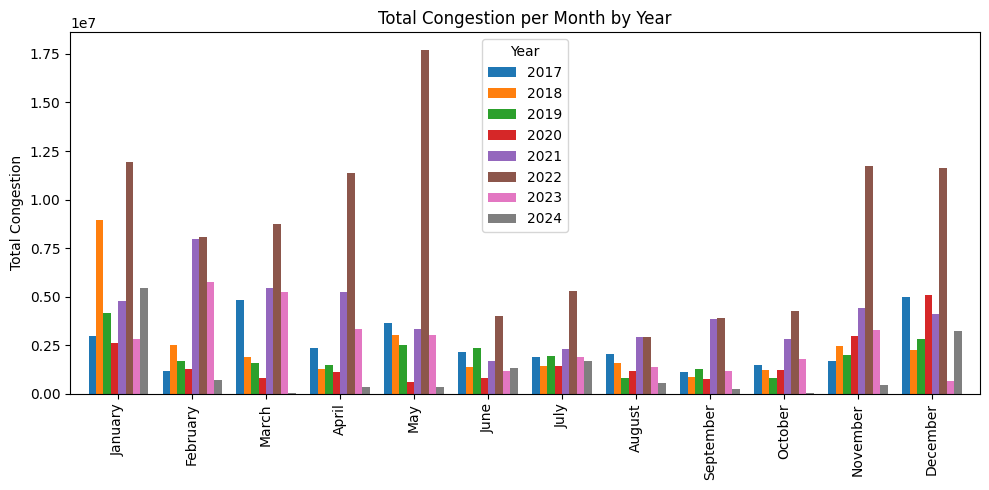

In [125]:
# total congestion by year-month
monthly_yearly = (
    df.groupby([df["Interval Start"].dt.year, df["Interval Start"].dt.month])[
        "Congestion"
    ]
    .sum()
    .unstack(level=0)
)

# label the index with month names
monthly_yearly.index = [calendar.month_name[m] for m in monthly_yearly.index]

fig, ax = plt.subplots(figsize=(10, 5))
monthly_yearly.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Total Congestion per Month by Year")
ax.set_ylabel("Total Congestion")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

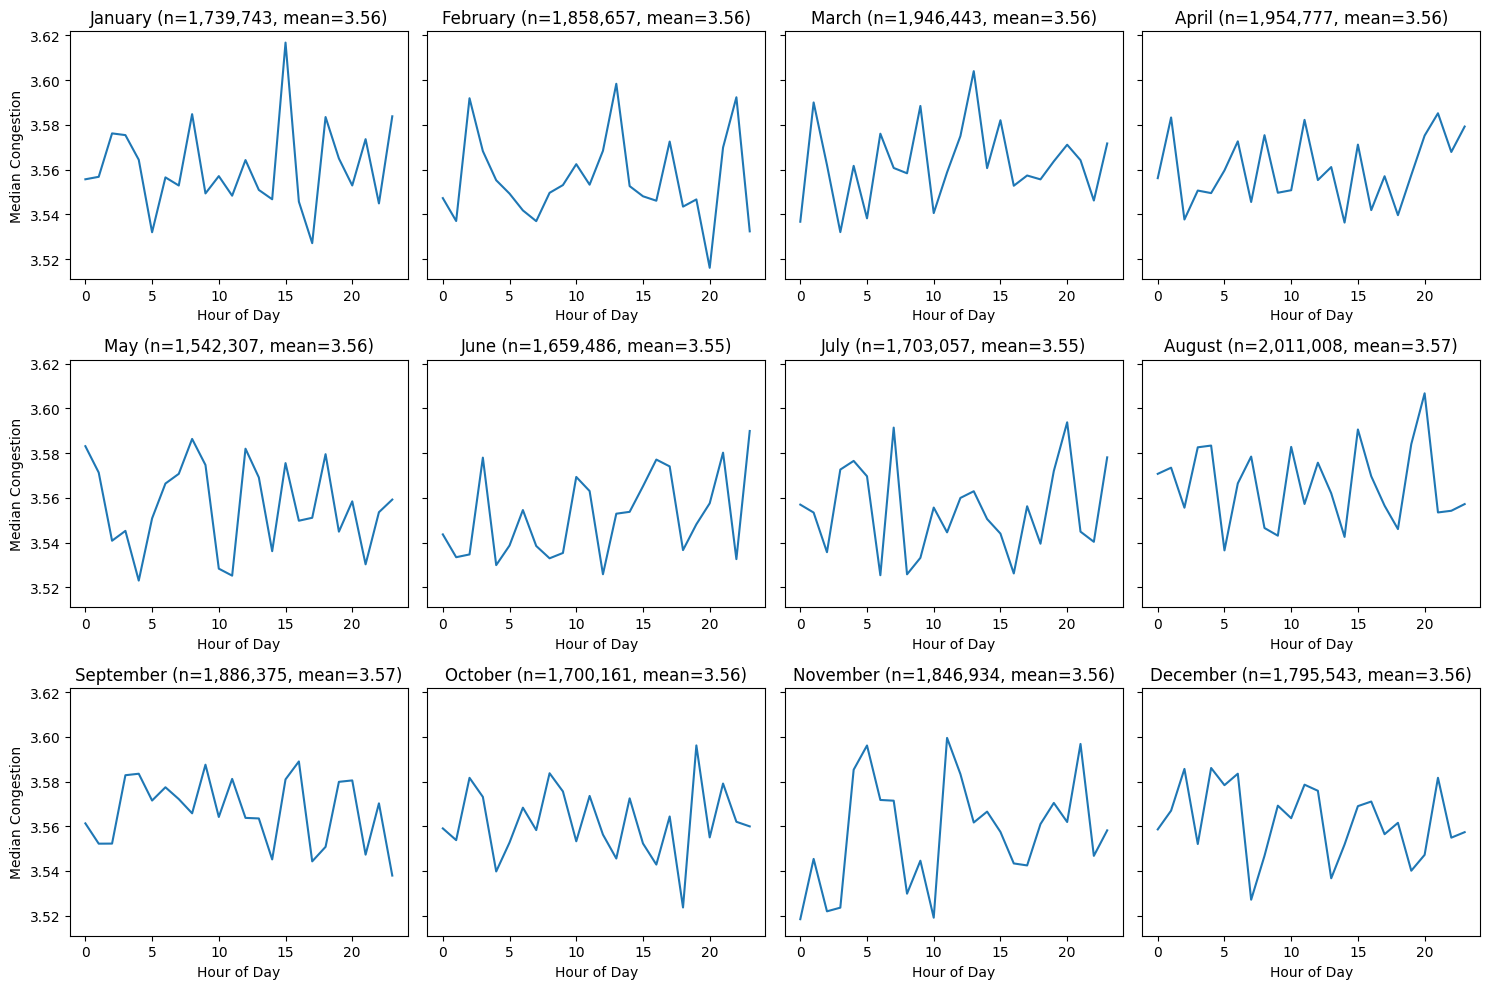

In [15]:
trimmed_df_sample = trimmed_df[trimmed_df["Interval Start"].dt.year.isin([2017, 2018, 2019, 2020, 2024])]

# get counts per month
counts = trimmed_df_sample["Interval Start"].dt.month.value_counts().sort_index()

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharey=True)
axes = axes.flatten()

mean_cong_month_hour = trimmed_df_sample.pivot_table(
    index=trimmed_df_sample["Interval Start"].dt.hour,
    columns=trimmed_df_sample["Interval Start"].dt.month,
    values="Congestion",
    aggfunc="mean",
)

for month, ax in zip(mean_cong_month_hour.columns, axes):
    # plot the mean congestion curve
    mean_cong_month_hour[month].plot(ax=ax)
    # annotate title with month name and count
    n = counts.get(month, 0)
    ax.set_title(
        f"{calendar.month_name[month]} (n={n:,}, mean={mean_cong_month_hour[month].mean():.2f})"
    )
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Median Congestion")

plt.tight_layout()
plt.show()

In [14]:
is_summer = trimmed_df["Interval Start"].dt.month.isin([6, 7, 8])

summer_cong = trimmed_df[is_summer].Congestion
non_summer_cong = trimmed_df[~is_summer].Congestion

# Observed difference in means
obs_diff = non_summer_cong.mean() - summer_cong.mean()

obs_diff

np.float64(0.0022060992136356816)

In [ ]:
from tqdm import tqdm
import numpy as np

np.random.seed(42)
n_iterations = 100
combined = trimmed_vals.to_numpy()
n_summer = len(summer_cong)

perm_diffs = []

# make sure about the one-sided/two-sided

for _ in tqdm(range(n_iterations)):
    np.random.shuffle(combined)
    perm_summer = combined[:n_summer]
    perm_non_summer = combined[n_summer:]
    perm_diffs.append(perm_non_summer.mean() - perm_summer.mean())

perm_diffs = np.array(perm_diffs)

# calculate p-value (two-sided  test)

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


In [13]:
p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

print(f"Observed difference in means: {obs_diff:.5f}")
print(f"P-value from permutation test: {p_value:.5f}")

Observed difference in means: -1.35276
P-value from permutation test: 0.00000


<Axes: ylabel='Frequency'>

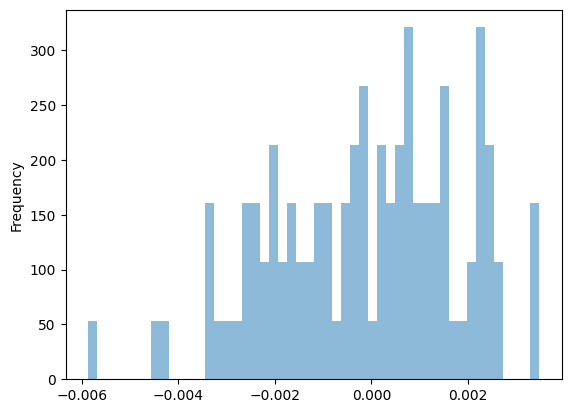

In [9]:
pd.Series(perm_diffs).plot(kind="hist", bins=50, density=True, alpha=0.5)

# What are the most congested pricing points?

Long Island

In [139]:
df[df["Interval Start"].dt.year == 2024].groupby("Location").Congestion.sum().sort_values(ascending=False).head(30)

Location
HUNTINGTON_RES_REC           101801.67000
FLOWRFLD_69_KV_BK1            80797.48000
STONY___BROOK                 79536.13000
KEDC PORT_JEFF_GT3            76991.52000
KEDC PORT_JEFF_GT2            76991.52000
PORT_JEFF_IC                  76959.07000
WM_FLOYD_69_KV_BK2            76231.22000
LISF___SOLAR                  75852.42000
GLOBAL GREEN_PORT_GT1         75357.96000
SOUTHOLD___IC                 75357.96000
EAST HAMPTON___GT             75340.12000
EAST_HAMPTON___DIESEL         75339.54000
SOUTH_FORK_WT_PWR             75339.54000
SOUTHOLD_69_KV_BK 2           75324.78000
SOUTH HAMPTN___IC             75323.50000
TIANA____69_KV_BK 1           75318.55000
MONTAUK___DIESEL              75307.00000
DEERFILD_69_KV_DEERFILD LD    75293.65000
SHOREHAM_IC_2                 75247.42000
SHOREHAM_IC_1                 75247.42000
PPL_SHRM_GT3                  75247.42000
PPL_SHRM_GT4                  75247.42000
CALVERTON___SOLAR             75219.95000
BROOKHAVEN___DRP         